# Imaging steps

## Step 1: Input & setup

In [1]:
import subprocess
# import multiprocess
import numpy as np
from astropy.io import fits
# %matplotlib ipympl
import matplotlib.pyplot as plt
from astropy import wcs
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
plt.style.use("default")
plt.rc('xtick', direction='in', top=True)
plt.rc('ytick', direction='in', right=True)
plt.rc('axes', linewidth=1.15)

plt.rc("mathtext", fontset="dejavuserif")

In [3]:
if not os.path.exists('../Data/Images'):
    os.system('mkdir ../Data/Images')

event_file = '../Data/Filtered_data/Merged/Merged_020_s05_TM0_Events.fits'

In [4]:
band_min = 0.2
band_max = 2.3

## Step 2: Creating Image and exposure map

In [ ]:
def run_evtool(input_name, output_name, emin, emax, gti_type='FLAREGTI', flag_type='0xe00fff30', pattern='15', telid='1 2 3 4 5 6 7', log_file=None):
    subprocess.run(['evtool', 
                    f'eventfiles={input_name}', 
                    f'outfile={output_name}', 
                    f'gti={gti_type}', 
                    f'flag={flag_type}', 
                    f'pattern={pattern}', 
                    f'emin={emin}', 
                    f'emax={emax}',
                    f'image=yes',
                    f'events=no',
                    f'telid={telid}'
                    ],
                    stdout=log_file,
                    stderr=log_file)
    
def run_expmap(input_eventlist, input_image, output_name, emin, emax, log_file=None):
    subprocess.run(['expmap', 
                    f'inputdatasets={input_eventlist}', 
                    f'templateimage={input_image}', 
                    f'mergedmaps={output_name}', 
                    f'emin={emin}', 
                    f'emax={emax}',
                    'withvignetting=yes',
                    'withweights=yes',
                    ],
                    stdout=log_file,
                    stderr=log_file)

: 

In [5]:
run_evtool(event_file, f'../Data/Images/merged_image_{int(band_min*1000)}_{int(band_max*1000)}.fits', 
           band_min, band_max, log_file=open(f'../Data/Images/merged_image_{int(band_min*1000)}_{int(band_max*1000)}.log', 'w+'))
run_expmap(event_file, f'../Data/Images/merged_image_{int(band_min*1000)}_{int(band_max*1000)}.fits', 
           f'../Data/Images/merged_expmap_{int(band_min*1000)}_{int(band_max*1000)}.fits', 
           band_min, band_max, log_file=open(f'../Data/Images/merged_expmap_{int(band_min*1000)}_{int(band_max*1000)}.log', 'w+'))

## Step 3: Exposure correction

In [27]:
def exp_corr(input_image, input_expmap, output_name):
    cts = fits.open(input_image)[0].data
    exp = fits.open(input_expmap)[0].data
    hdr = fits.getheader(input_image)

    exp_corr = cts/exp

    fits.writeto(output_name, exp_corr, header=hdr, overwrite=True)

In [28]:
exp_corr(f'../Data/Images/merged_image_{int(band_min*1000)}_{int(band_max*1000)}.fits',
         f'../Data/Images/merged_expmap_{int(band_min*1000)}_{int(band_max*1000)}.fits',
         f'../Data/Images/merged_exp_corr_{int(band_min*1000)}_{int(band_max*1000)}.fits')

## Step 4: Viewing the image

In [5]:
image = fits.open(f'../Data/Images/merged_exp_corr_{int(band_min*1000)}_{int(band_max*1000)}.fits')[0]
image_wcs = wcs.WCS(image.header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58930.414826 from DATE-OBS.
Set MJD-END to 58938.584398 from DATE-END'. [astropy.wcs.wcs]


In [57]:
def plot_image(image, image_wcs, ra_l=None, ra_u=None, dec_l=None, dec_u=None, vmin=0, vmax=1, sigma=2, smooth=True, limits=True):
    fig = plt.figure(1, figsize=(6, 6))
    ax = plt.subplot(projection=image_wcs)

    if smooth:
        smoothed_image = gaussian_filter(image.data, sigma=sigma)
        im = ax.imshow(smoothed_image, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)
    else:
        im = ax.imshow(image.data, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)

    ra_ax = ax.coords[0]
    ra_ax.set_format_unit(unit='degree')

    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    
    if limits:
        if ra_l is not None and ra_u is not None and dec_l is not None and dec_u is not None:
            ra_u, dec_u = image_wcs.all_world2pix(ra_u, dec_u, 0)
            ra_l, dec_l = image_wcs.all_world2pix(ra_l, dec_l, 0)
            ax.set_xlim(ra_u, ra_l)
            ax.set_ylim(dec_l, dec_u)
        else:
            raise ValueError("ra_l, ra_u, dec_l, and dec_u must be provided when limits=True")
    
    ax.grid(color='white', lw=1, ls='--', alpha=0.5)

    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Counts')

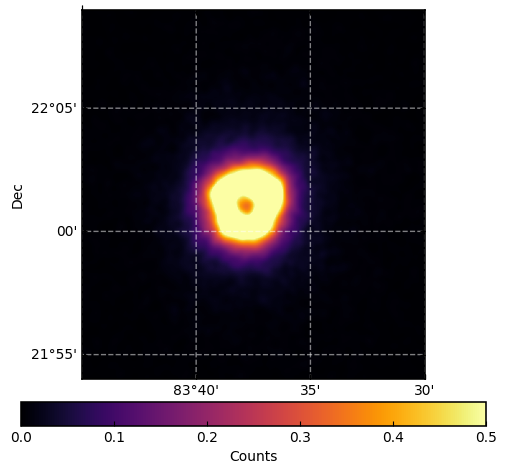

In [60]:
plot_image(image, image_wcs, 83.5, 83.75, 21.9, 22.15, 0, 0.5, limits=True)

In [67]:
def get_ra_dec_range(image_data, image_wcs):
    ny, nx = image_data.shape
    corners = [[0, 0], [0, ny], [nx, 0], [nx, ny]]
    world_coords = image_wcs.all_pix2world(corners, 0)
    ra_values = world_coords[:, 0]
    dec_values = world_coords[:, 1]
    ra_min, ra_max = ra_values.min(), ra_values.max()
    dec_min, dec_max = dec_values.min(), dec_values.max()

    data_max = np.max(image_data)
    data_min = np.min(image_data)

    return ra_min, ra_max, dec_min, dec_max, data_min, data_max

ra_min, ra_max, dec_min, dec_max, data_min, data_max = get_ra_dec_range(image.data, image_wcs)

In [77]:
import ipywidgets as widgets
from ipywidgets import interact

v_slider = widgets.FloatRangeSlider(value=[0, 0.8], min=data_min, max=data_max, step=(data_max-data_min)/10, description='vmin/vmax')
ra_slider = widgets.FloatRangeSlider(value=[83.5, 83.75], min=ra_min, max=ra_max, step=(ra_max-ra_min)/15, description='RA range')
dec_slider = widgets.FloatRangeSlider(value=[21.9, 22.15], min=dec_min, max=dec_max, step=(dec_max-dec_min)/15, description='Dec range')

def interactive_plot(v_range, ra_range, dec_range):
    vmin, vmax = v_range
    ra_l, ra_u = ra_range
    dec_l, dec_u = dec_range
    plot_image(image, image_wcs, ra_l, ra_u, dec_l, dec_u, vmin, vmax)

interact(interactive_plot, v_range=v_slider, ra_range=ra_slider, dec_range=dec_slider)

# interact(interactive_plot, vmin=vmin_slider, vmax=vmax_slider, ra_l=ra_l_slider, ra_u=ra_u_slider, dec_l=dec_l_slider, dec_u=dec_u_slider)

interactive(children=(FloatRangeSlider(value=(0.0, 0.8), description='vmin/vmax', max=1.3301137662187925), Flo…

<function __main__.interactive_plot(v_range, ra_range, dec_range)>

## Step 5: RGB image